In [1]:
import pandas as pd
import numpy as np
import scipy.linalg

from scipy.sparse.linalg import cg
from scipy.linalg import eigh, solve

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
from DynamicalSystems.utils import plot_eigs, modified_QR , rSVD
import seaborn as sns

def print_timescale(eigenvalues, stride, timestep, units=''):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around((-np.log(np.abs(ev))**-1)*stride*timestep, decimals = 2)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            freq = None
            data.append((decay_length, freq))
        else:
            #Imaginary eigenvalue
            freq = np.around(2*np.pi*(np.angle(ev)**-1)*stride*timestep, decimals=2)
            if freq > 0:
                data.append((decay_length, freq))
        
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Frequency: {x[1]} {units}")


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


# Standardizing dataset

In [2]:
df_pd = pd.read_pickle("full_dataframe").interpolate()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)
    df_pd[df_pd.filter(regex= m + "_*").columns] -= mean
    df_pd[df_pd.filter(regex= m + "_*").columns] /= std
#df = df_pd.filter(regex= "DEWP*").to_numpy()
df = df_pd.to_numpy()

#### Selecting timestep, kernel, desired rank & regularizer

In [3]:
def subsample_data(df, n_timesteps, full_data=True, shift = 0):
    """Subsample the dataframe every timestep

    Args:
        df (np.ndarray): dataframe
        n_timesteps (int): number of original timesteps to skip because of subsamplign
        full_data (bool, optional): Retain full data or subsample only one of the possible n_timesteps subsequences. Defaults to True.
    """
    nan_mask = np.isnan(df).any(axis=1)
    dataset_indexes = []

    if full_data:
        for idx, val in enumerate(nan_mask[:-n_timesteps -shift]):
            if val == False:
                if nan_mask[idx + n_timesteps] == False:
                    dataset_indexes.append((idx, idx+ n_timesteps))
    else:
        for idx in range(int(df.shape[0]/n_timesteps)):
            try:
                _in = nan_mask[idx*n_timesteps] == False
                _out = nan_mask[(idx + 1)*n_timesteps] == False
                cond = _in and _out

                if shift > 0:
                    _in_shift = nan_mask[idx*n_timesteps + shift] == False
                    _out_shift = nan_mask[(idx + 1)*n_timesteps + shift] == False
                    cond_shift = _in_shift and _out_shift
                else:
                    cond_shift = True
                if cond and cond_shift:
                    dataset_indexes.append((idx*n_timesteps, (idx+1)*n_timesteps))
            except:
                pass                    

    dataset_indexes = np.array(dataset_indexes)
    if shift == 0:
        inputs = df[dataset_indexes[:,0]]
        evolved_inputs = df[dataset_indexes[:,1]]
    else:
        inputs = np.hstack([df[dataset_indexes[:,0] + i*shift] for i in range(2)])
        evolved_inputs = np.hstack([df[dataset_indexes[:,1] + i*shift] for i in range(2)])
    return inputs, evolved_inputs

In [4]:
n_timesteps = 6 #In hours

regularizer = 1e-10
l = np.float32(np.sqrt(df.shape[1]))
X, Y = subsample_data(df, n_timesteps, full_data=False, shift=12)
nu = 1.5
kernel = Matern(nu = nu, length_scale=l)
num_samples = 2000
rank = 5
X_train, Y_train = X[:num_samples], Y[:num_samples]

In [5]:
K = KoopmanRegression(X_train, Y_train, kernel, regularizer = regularizer, rank=None, center_kernel=False, backend='cpu')

In [5]:
K_r = KoopmanRegression(X_train, Y_train, kernel, regularizer = regularizer, rank=rank, center_kernel=False, backend='cpu')

NameError: name 'X_train' is not defined

In [49]:
U, V, svals2 = rSVD(K.K_X, K.K_Y, reg = regularizer, rank = 100, powers=2, offset=10)

[0.22536857 0.06071681 0.03329573 0.02841684 0.01616332 0.01489957
 0.01279879 0.01086708 0.00940399 0.0080151  0.00752522 0.00589742
 0.00559752 0.00527384 0.00506129 0.00487914 0.00450778 0.00438575
 0.00407982 0.00367827 0.00354253 0.00333742 0.00325524 0.00312946
 0.0030548  0.00290181 0.00284511 0.00271815 0.00262926 0.00249078
 0.00245037 0.00237131 0.00230058 0.00224713 0.00219164 0.00212014
 0.0021011  0.00202189 0.0018704  0.00184658 0.00180922 0.00176116
 0.00174447 0.00167553 0.00161872 0.00161273 0.00159637 0.00158331
 0.00154486 0.00151921 0.00148687 0.00145865 0.00144281 0.00142833
 0.00142241 0.00137988 0.00135035 0.00133129 0.00131723 0.00127907
 0.00127369 0.00126405 0.00124993 0.00121964 0.00119862 0.00118708
 0.00117595 0.00117058 0.00114838 0.00111648 0.00110784 0.00109523
 0.00108132 0.00105748 0.00104918 0.00104496 0.00102697 0.00101679
 0.00099805 0.00097039 0.00095327 0.00094224 0.00093468 0.00092891
 0.00091745 0.00090572 0.00089841 0.00087716 0.00086936 0.0008

In [50]:
np.linalg.norm(K.K_Y@K_r.V/K_r.V.shape[0] - (K_r.V+K_r.V.shape[0]*regularizer*K_r.U)@np.diag(K_r.sigma_sq),ord=1)

NameError: name 'K_r' is not defined

In [53]:
K_r.V[:,0]-V[:,0]

array([-1.6557585 , -1.6004544 , -1.63979562, ..., -2.14568303,
       -1.8197314 , -2.02985172])

In [45]:
np.linalg.norm(K_r.U@K_r.V.T- U@V.T,ord=2) / np.linalg.norm(K_r.U@K_r.V.T,ord=2)

1.0557378091955925

In [151]:
true_eigs, _, _ = K.eig()

In [152]:
eigs, _, _ = K_r.eig()

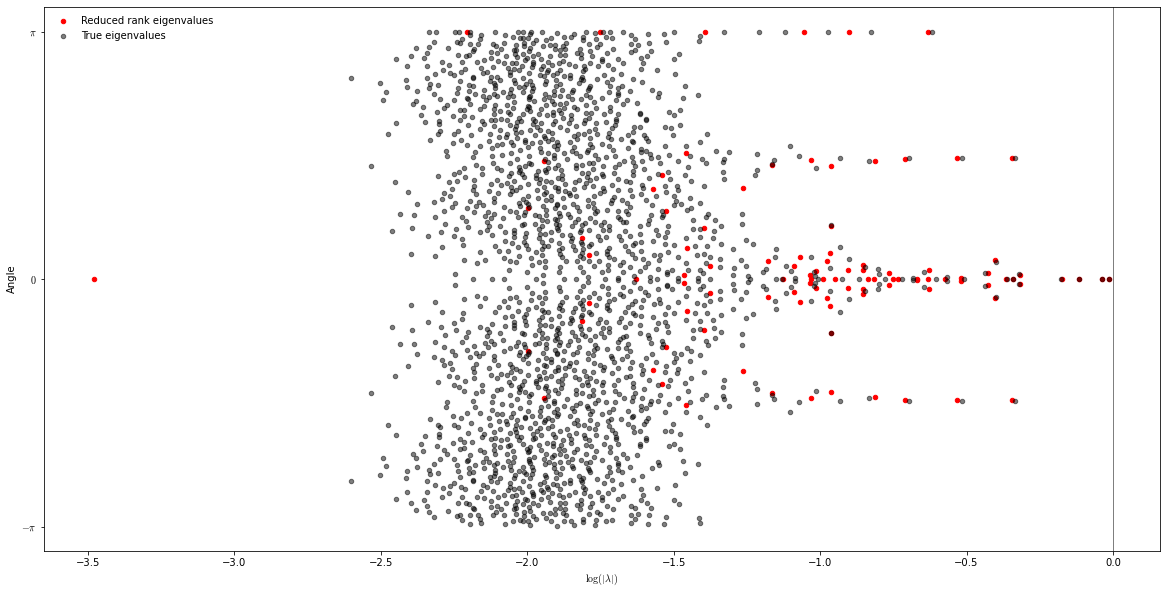

In [153]:
plt.figure(figsize=(20,10))
n = 1
plt.scatter(np.log(np.abs(eigs)), np.angle(eigs), c='r', s=20, label='Reduced rank eigenvalues')
plt.scatter(np.log(np.abs(true_eigs**n)), np.angle(true_eigs**n), c='k', s=20, alpha=0.5, label='True eigenvalues')
plt.axvline(x=0, color='k', lw=0.5)
plt.yticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
plt.xlabel(r"$\log(\vert \lambda \vert)$")
plt.ylabel(r"Angle")
#plt.xlim(-.00002,0.000002)
plt.legend(frameon=False)
plt.savefig("figs/eigs_comparison.pdf", bbox_inches='tight')

In [154]:
U, S, V = scipy.linalg.svd(K.K_X)

Kr = U[:,:100]@ np.diag(S[:100])@ V[:100,:]

eigs_dmd = scipy.linalg.eigvals(np.linalg.pinv(Kr)@K.K_YX)

true_eigs = true_eigs[0:100]
eigs = eigs[0:100]
eigs_dmd = eigs_dmd[0:100]

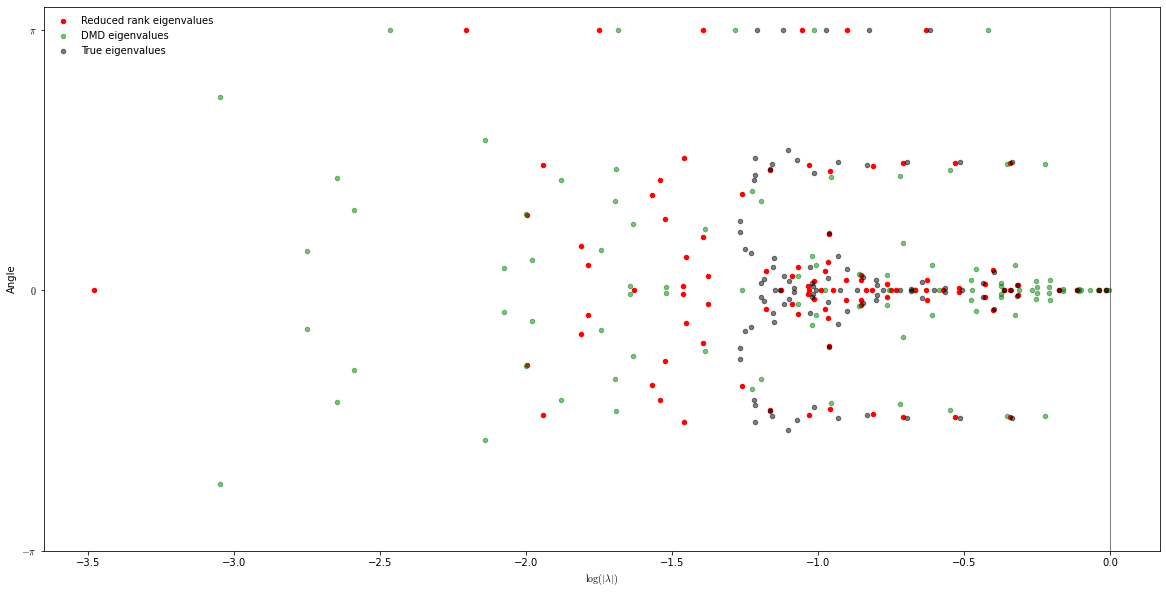

In [155]:
plt.figure(figsize=(20,10))
n = 1
plt.scatter(np.log(np.abs(eigs)), np.angle(eigs), c='r', s=20, label='Reduced rank eigenvalues')
plt.scatter(np.log(np.abs(eigs_dmd)), np.angle(eigs_dmd), c='g', s=20, alpha=0.5, label='DMD eigenvalues')
plt.scatter(np.log(np.abs(true_eigs**n)), np.angle(true_eigs**n), c='k', s=20, alpha=0.5, label='True eigenvalues')
plt.axvline(x=0, color='k', lw=0.5)
plt.yticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
plt.xlabel(r"$\log(\vert \lambda \vert)$")
plt.ylabel(r"Angle")
#plt.xlim(-.00002,0.000002)
plt.legend(frameon=False)
plt.savefig("figs/eigs_comparison.pdf", bbox_inches='tight')

In [7]:
C = K.K_YX@K.U
evals, V_tilde =  scipy.linalg.eig(K.V.T@C)
D = (K.U.T)@K.K_X@K.U@V_tilde

In [9]:
modes = scipy.linalg.solve(D, K.U.T@K.X)

In [40]:
observables = df_pd.columns.to_numpy()
prefix = 'DEWP'
idxs_list = []
for idx, f in enumerate(observables):
    if f.startswith(prefix):
        if (idx +1) < observables.shape[0]//2:
            idxs_list.append(idx)
idxs_list_DEWP = np.array(idxs_list)

In [49]:
idx = 0
m_PM = modes[:,idxs_list_PM[idx]]
m_DEWP = modes[:,idxs_list_DEWP[idx]]

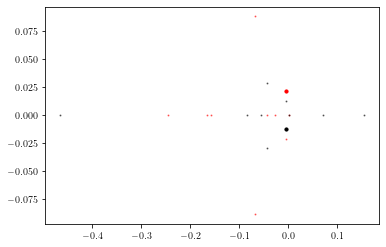

In [72]:
k = 0

plt.scatter(np.real(m_PM), np.imag(m_PM), c='r', s=1, alpha = 0.5)
plt.scatter(np.real(m_DEWP), np.imag(m_DEWP), c='k', s=1, alpha = 0.5)

plt.scatter(np.real(m_PM)[k], np.imag(m_PM)[k], c='r', s=10)
plt.scatter(np.real(m_DEWP)[k], np.imag(m_DEWP)[k], c='k', s=10)

# Sine wave

In [58]:
time_step = 0.05
x = np.arange(0,10,time_step)
f = 2
sigma = 1
#y = np.sin(f*x)[:, np.newaxis]
__y = 5*np.sin(f*x)
_y = 5*np.sin(f*x) + sigma*np.random.randn(*x.shape) 
shift = 10
y_shift = np.empty((x.shape[0] -shift,shift), dtype = x.dtype)
y__shift = np.empty((x.shape[0] -shift,shift), dtype = x.dtype)
for k in range(shift):
    y_shift[:,k] = _y[k:-shift+k]
    y__shift[:,k] = __y[k:-shift+k]
# y_shift = np.empty((x.shape[0] -shift,2), dtype = x.dtype)
# y_shift[:,0] = _y[:-shift]
# y_shift[:,1] = _y[shift:]
kernel_RBF = RBF(length_scale=1)
kernel_linear = Linear(coef0=0.)
x_axis = x[:-shift-1]
split = int(x.shape[0] *0.5)
print(split)
X_train = y_shift[:-1][:split]
Y_train =  y_shift[1:][:split]

X_full = y_shift[:-1]
Y_full =  y_shift[1:]
Y__full =  y__shift[1:]



100


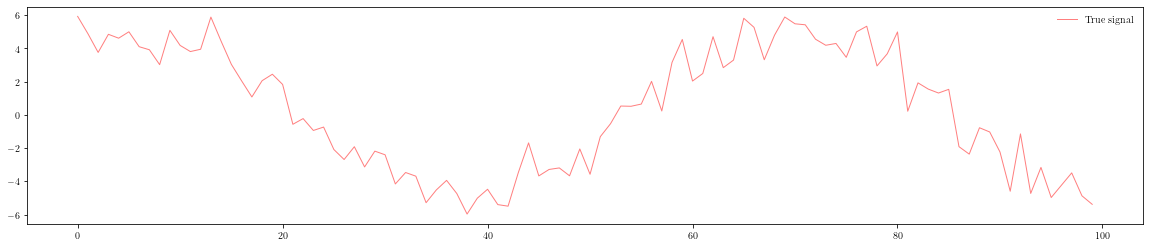

In [59]:
plt.figure(figsize=(20,4))
#plt.plot(X_train[:,0], c ='blue' ,lw = 1 , alpha=0.5, label='True signal')
plt.plot(X_train[:,-1], c ='red' ,lw = 1 , alpha=0.5, label='True signal')
plt.legend(frameon=False)

In [60]:
regularizer = 1e-7
regularizer_ = None
rank = 2
#kernel = RBF(length_scale=20)
kernel = Linear(coef0=0.)
K = KoopmanRegression(X_train, Y_train, kernel, regularizer = regularizer, rank=None, center_kernel=False, backend='cpu')
K_r3 = KoopmanRegression(X_train, Y_train, kernel, regularizer = regularizer, rank=rank, center_kernel=False, backend='cpu', rank_reduction= 'r3')
K_pcr = KoopmanRegression(X_train, Y_train, kernel, regularizer= regularizer_, rank=rank, center_kernel=False, backend='cpu', rank_reduction= 'pcr')
K_r4 = KoopmanRegression(X_train, Y_train, kernel, regularizer = regularizer, rank=None, center_kernel=False, backend='cpu', rank_reduction= 'r4', powers=0, offset=100)

INIT: Computing low-rank-projection via Reduced Rank Regression
INIT: Computing low-rank-projection via Principal Component Regression
INIT: Computing low-rank-projection via Randomized Reduced Rank Regression
Numerical rank of the output kernel is approximatly 2 which is used.
Attention! l1 Error in GEP is 421026.46685551613


In [61]:
f = lambda x: x[:,0]

In [62]:
K_r3.eig()
x_r3 = K_r3.modal_decompostion(f = f, time_step=0.05)
x_r3_ = x_r3(X_train[0,:],x)

(2,)


In [63]:
K_r4.eig()
x_r4 = K_r4.modal_decompostion(f = f, time_step=0.05)
x_r4_ = x_r4(X_train[0,:],x)

(2,)


In [64]:
K_pcr.eig()
x_pcr = K_r3.modal_decompostion(f = f, time_step=0.05)
x_pcr_ = x_pcr(X_train[0,:],x)

(2,)


NameError: name 'x_pred' is not defined

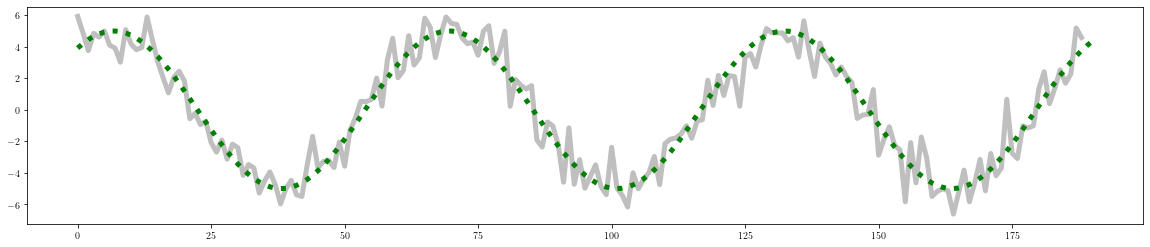

In [65]:
plt.figure(figsize=(20,4))
plt.plot(X_full[:,-1], c ='gray' ,lw = 5 , alpha=0.5, label='True signal')
plt.plot(__y[shift-1:], 'g:' , lw = 5, label='Denoised signal')
plt.plot(x_pred[:,-1], c = 'blue' , lw = 3, label='Predicted R3 signal')
plt.plot(x_pred[:,-1], 'k--' , label='Predicted R4 signal')
#plt.plot(x_pred_f[:,-1], c = 'black' , label='Predicted signal 2')
plt.plot(x_dmd[:,-1], 'r--' , lw = 3, label='Predicted PCR signal')

plt.axvline(x=split, c='gray')
#plt.axhline(y=0)
plt.legend(frameon=False)
#plt.xlim(400,800)

(0.0, 8.0)

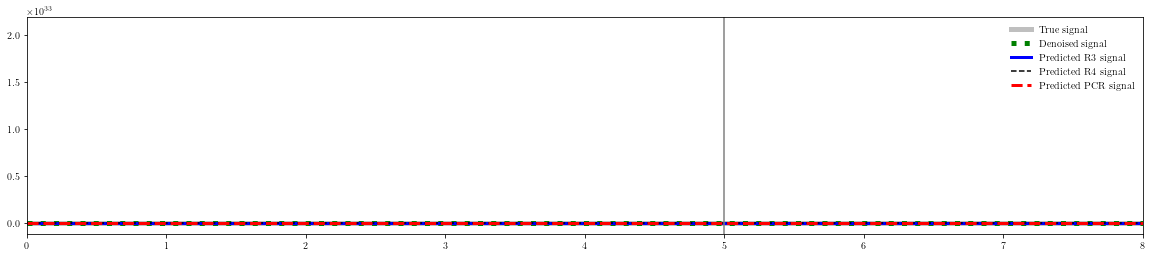

In [67]:
plt.figure(figsize=(20,4))
plt.plot(x,_y, c ='gray' ,lw = 5 , alpha=0.5, label='True signal')
plt.plot(x,__y, 'g:' , lw = 5, label='Denoised signal')
plt.plot(x,x_r3_, c = 'blue' , lw = 3, label='Predicted R3 signal')
plt.plot(x,x_r4_, 'k--' , label='Predicted R4 signal')
#plt.plot(x_pred_f[:,-1], c = 'black' , label='Predicted signal 2')
plt.plot(x,x_pcr_, 'r--' , lw = 3, label='Predicted PCR signal')

plt.axvline(x=split*time_step, c='gray')
#plt.axhline(y=0)
plt.legend(frameon=False)
plt.xlim(0,8)
#plt.ylim(-50,50)

In [9]:
print(f"Risk for PCR on the training set is {K_dmd.risk():.2e} and on the validation set is {K_dmd.risk((X_full[split:,:],Y__full[split:,:])):.2e}")
print(f"Risk for R3 on the training set is {K_.risk():.2e} and on the validation set {K_.risk((X_full[split:,:],Y__full[split:,:])):.2e}")
print(f"Risk for R4 on the training set is {K_r4.risk():.2e} and on the validation set is {K_r4.risk((X_full[split:,:],Y__full[split:,:])):.2e}")
print("-"*90)
print(f"Risk of R3 on the training set is {K_.risk() / K_dmd.risk()*100:.2f}% and on the validation set {K_.risk( (X_full[split:,:],Y__full[split:,:]) ) / K_dmd.risk( (X_full[split:,:],Y__full[split:,:]) )*100:.2f}% of the PCR Risk ")
print("-"*90)
print(f"Spectral error for PCR on the training set is {K_dmd.spectral_error().sum():.2e} and on the validation set is {K_dmd.spectral_error((X_full[split:,:],Y__full[split:,:])).sum():.2e}")
print(f"Spectral error for R3 on the training set is {K_.spectral_error().sum():.2e} and on the validation set {K_.spectral_error((X_full[split:,:],Y__full[split:,:])).sum():.2e}")
print(f"Spectral error for R4 on the training set is {K_r4.spectral_error().sum():.2e} and on the validation set is {K_r4.spectral_error((X_full[split:,:],Y__full[split:,:])).sum():.2e}")

Risk for PCR on the training set is 9.34e-01 and on the validation set is 3.19e-01
Risk for R3 on the training set is 7.96e-01 and on the validation set 4.46e-01
Risk for R4 on the training set is 2.87e+05 and on the validation set is 2.37e+05
------------------------------------------------------------------------------------------
Risk of R3 on the training set is 85.19% and on the validation set 139.70% of the PCR Risk 
------------------------------------------------------------------------------------------
Spectral error for PCR on the training set is 6.89e-02 and on the validation set is 4.85e-02
Spectral error for R3 on the training set is 7.13e-02 and on the validation set 4.89e-02
Spectral error for R4 on the training set is 4.17e+00 and on the validation set is 3.73e+00


In [17]:
K.eig()
true_eigs = K.evals[0:rank]
eigs = K_.evals[0:rank]
eigs_dmd = K_dmd.evals[0:rank]
print(f'True evals {np.round(true_eigs,2)}')
print(f'RR evals {np.round(eigs,2)}')
print(f'DMD evals {np.round(eigs_dmd,2)}')


True evals [ 0.9 +0.08j  0.9 -0.08j  0.4 +0.53j  0.4 -0.53j -0.03+0.82j -0.03-0.82j
 -0.51+0.58j -0.51-0.58j -0.66+0.21j -0.66-0.21j]
RR evals [ 0.9 +0.08j  0.9 -0.08j  0.41+0.53j  0.41-0.53j -0.03+0.82j -0.03-0.82j
 -0.51+0.58j -0.51-0.58j -0.67+0.22j -0.67-0.22j]
DMD evals [ 0.9 +0.08j  0.9 -0.08j  0.4 +0.53j  0.4 -0.53j -0.03+0.82j -0.03-0.82j
 -0.51+0.58j -0.51-0.58j -0.66+0.21j -0.66-0.21j]


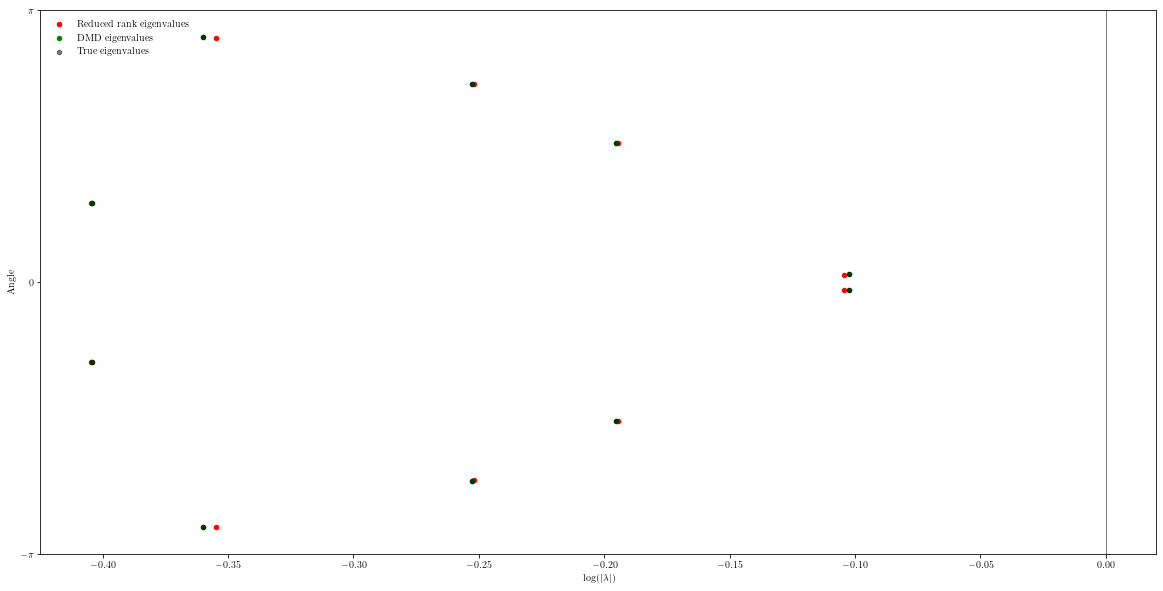

In [18]:
plt.figure(figsize=(20,10))
n = 1
plt.scatter(np.log(np.abs(eigs)), np.angle(eigs), c='r', s=20, label='Reduced rank eigenvalues')
plt.scatter(np.log(np.abs(eigs_dmd)), np.angle(eigs_dmd), c='g', s=20, label='DMD eigenvalues')
plt.scatter(np.log(np.abs(true_eigs**n)), np.angle(true_eigs**n), c='k', s=20, alpha=0.5, label='True eigenvalues')
plt.axvline(x=0, color='k', lw=0.5)
plt.yticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
plt.xlabel(r"$\log(\vert \lambda \vert)$")
plt.ylabel(r"Angle")
#plt.xlim(-.002,0.002)
plt.legend(frameon=False)
plt.savefig("figs/eigs_comparison.pdf", bbox_inches='tight')



In [192]:
U, V, sigma_sq = rSVD(K.K_X,K.K_Y, reg = regularizer, rank = 5, powers=1, offset=10)

Actual rank is smaller! Detected rank is 4
[ 4.14772535e-01  1.43872643e-01 -1.07898632e-18 -5.55704349e-17]
Attention! l1 Error in GEP is 158.14502815955882


### Toy example

In [35]:
def dinsys(m, sigma = 0.25, p = 0.5):
    np.random.RandomState = 0
    x = np.zeros((m,2),dtype=np.float64)
    x[0,0] = 1.
    for k in range(0,m):
        #v = (x[k-1] + sigma*np.random.randn(2))
        #v = v/np.sqrt((v**2).sum())
        #x[k] = v * 2/(1+np.random.binomial(1,p))
        x[k,0] = np.cos(k*2*np.pi/50 + sigma*np.random.randn())
        x[k,1] = np.sin(k*2*np.pi/50 + sigma*np.random.randn())
        #x[k] =+ sigma*np.random.randn(2)
    return x


In [36]:
n = 500
x = dinsys(n)
x = np.reshape(x,(250,4))
n = x.shape[0]
n_pred = 50

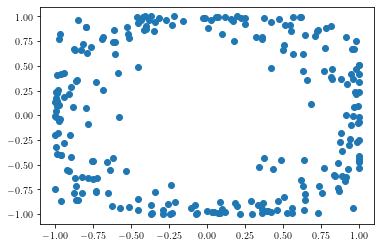

In [37]:
plt.scatter(x[:,0],x[:,1])

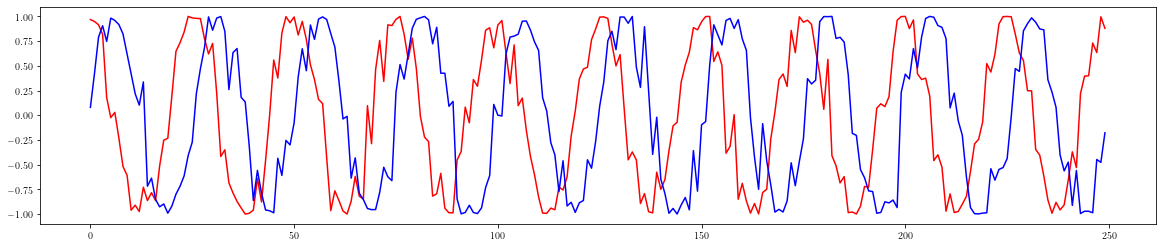

In [38]:
plt.figure(figsize=(20,4))
plt.plot(range(x.shape[0]),x[:,0],'r')
plt.plot(range(x.shape[0]),x[:,1],'b')

In [59]:
kernel = RBF(length_scale=1)
#kernel = Linear(coef0=0.)
l = 0.1
nu = 1.5
#kernel = Matern(nu = nu, length_scale=l)

regularizer = 1e-3
X_train = x[:-n_pred,:]
Y_train =  x[1:-n_pred+1,:]
X_test = x[-n_pred:,:]

rank = 10

In [60]:
K = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=None, center_kernel=False, backend='cpu')
K_10 = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=rank, center_kernel=False, backend='cpu')

INIT: Computing low-rank-projection
Error compared to full rank is 0.004976903382182459
Sigma^2 are [0.29501734 0.19938126 0.18722683 0.07453828 0.07031561 0.01916415
 0.0167079  0.00346178 0.00282356 0.0010306 ]


In [61]:
n_evals = rank
U, S, V = scipy.linalg.svd(K.K_X)
Kr = U[:,:n_evals]@ np.diag(S[:n_evals])@ V[:n_evals,:]
eigs_dmd = scipy.linalg.eigvals(np.linalg.pinv(Kr)@K.K_YX)

In [62]:
true_eigs, lv, rv = K.eig()
eigs, lv, rv = K_10.eig()

In [63]:
true_eigs = true_eigs[0:n_evals]
eigs = eigs[0:n_evals]
eigs_dmd = eigs_dmd[0:n_evals]

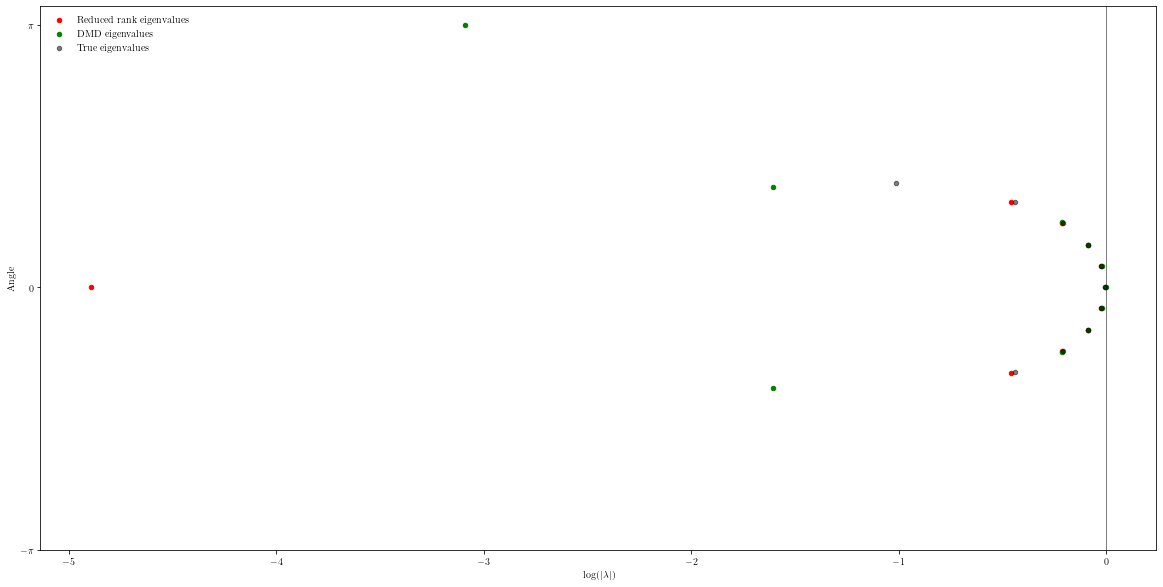

In [64]:
plt.figure(figsize=(20,10))
plt.scatter(np.log(np.abs(eigs)), np.angle(eigs), c='r', s=20, label='Reduced rank eigenvalues')
plt.scatter(np.log(np.abs(eigs_dmd)), np.angle(eigs_dmd), c='g', s=20, label='DMD eigenvalues')
plt.scatter(np.log(np.abs(true_eigs)), np.angle(true_eigs), c='k', s=20, alpha=0.5, label='True eigenvalues')
plt.axvline(x=0, color='k', lw=0.5)
plt.yticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
plt.xlabel(r"$\log(\vert \lambda \vert)$")
plt.ylabel(r"Angle")
#plt.xlim(-2,0.000002)
plt.legend(frameon=False)
plt.savefig("figs/eigs_comparison.pdf", bbox_inches='tight')

In [65]:
print(f'True eigs {np.round(true_eigs,4)}')
print(f'DMD eigs {np.round(eigs_dmd,4)}')
print(f'RRR eigs {np.round(eigs,4)}')

True eigs [0.995 +0.j     0.9451+0.243j  0.9451-0.243j  0.8013+0.4439j
 0.8013-0.4439j 0.588 +0.5617j 0.588 -0.5617j 0.3396+0.5462j
 0.3396-0.5462j 0.1138+0.3445j]
DMD eigs [ 0.997 +0.j      0.9482+0.2425j  0.9482-0.2425j  0.8014+0.4459j
  0.8014-0.4459j  0.5761+0.5648j  0.5761-0.5648j  0.0725+0.1873j
  0.0725-0.1873j -0.0456+0.j    ]
RRR eigs [0.0075+0.j     0.3281+0.5382j 0.3281-0.5382j 0.9947+0.j
 0.9448+0.2427j 0.9448-0.2427j 0.7997+0.4432j 0.7997-0.4432j
 0.5831+0.5599j 0.5831-0.5599j]


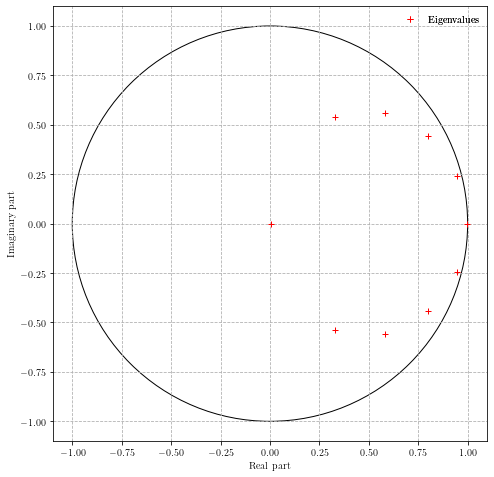

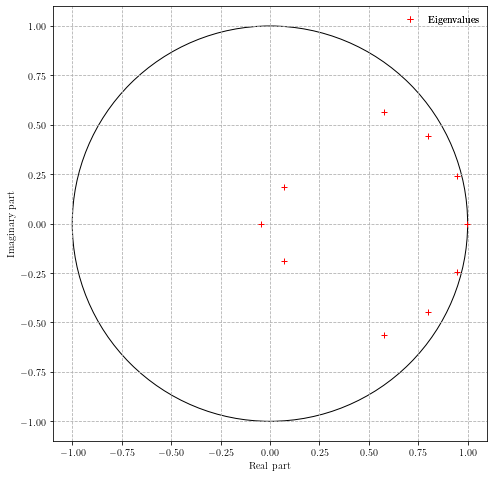

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

In [66]:
plot_eigs(eigs, log = None)
plot_eigs(eigs_dmd, log = None)

In [67]:
idx_0 = n - n_pred
x_pred = [x[idx_0]]
n_steps = n_pred
for _ in range(n_steps):
    x_pred.append(K.forecast(x_pred[-1]))
x_pred = np.array(x_pred)
x_true = x[idx_0:(idx_0 + n_steps  +1)]

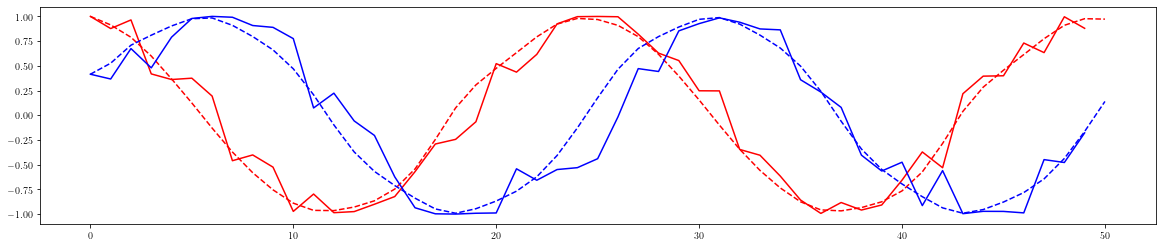

In [68]:
plt.figure(figsize=(20,4))
plt.plot(range(x_true.shape[0]),x_true[:,0],'r')
plt.plot(range(x_pred.shape[0]),x_pred[:,0],'r--')
plt.plot(range(x_true.shape[0]),x_true[:,1],'b')
plt.plot(range(x_pred.shape[0]),x_pred[:,1],'b--')


In [73]:
modes = K_10.modes()

In [50]:
K_10.kernel(K.X[0],K.X,backend='cpu').shape

(1, 200)

In [51]:
evecs0 = (K_10.kernel(K.X[0],K.X,backend='cpu') @ rv)

In [76]:
evecs0 @ modes

array([[-1.14857005+0.07727305j,  0.15268233+0.14157268j,
        -1.22124106+0.09264818j, -0.14605683+0.19028214j]])

In [81]:
def modal_forcast(KR, m, x0 = None):
    if x0 is None:
        x0=KR.X[0]
    dim = KR.X.shape[1]
    n = K.X.shape[0]
    x_pred = np.zeros((m,dim),dtype=np.float64)
    revecs_0 = (KR.kernel(x0,KR.X,backend=K.backend) @ KR.revecs)
    for k in range(m):
        x_pred[k] = np.real(((KR.evals**k * revecs_0) @ KR.modes).reshape(dim))
    return x_pred

In [70]:
x_pred = modal_forcast(K, eigs,modes,rv,250,K.X[0])

In [71]:
print(x_pred[0],x[0])

[ 0.0397823  -0.0278413   0.02243886 -0.00315338] [0.96813304 0.07943138 0.9540349  0.20460053]


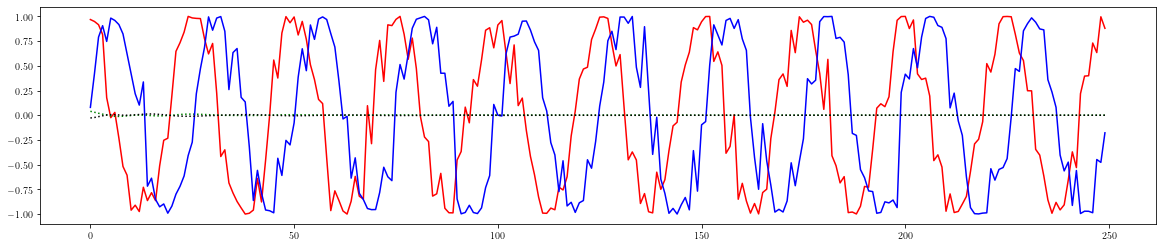

In [72]:
plt.figure(figsize=(20,4))
plt.plot(range(x.shape[0]),x[:,0],'r')
plt.plot(range(x_pred.shape[0]),x_pred[:,0],'g:')

plt.plot(range(x.shape[0]),x[:,1],'b')
plt.plot(range(x_pred.shape[0]),x_pred[:,1],'k:')

In [19]:
X_train[0][np.newaxis]

array([[-0.02639858,  0.8975747 ]])